In [33]:
# Import necessary libraries
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [34]:

# Connect to the SQLite database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [35]:
# Print all of the classes mapped to the Base
print(Base.classes.keys())

['measurement', 'station']


In [36]:

# Save references to the classes named station and measurement
Station = Base.classes.station
Measurement = Base.classes.measurement


In [37]:

# Create a session
session = Session(engine)


# Exploratory Precipitation Analysis

In [38]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

most_recent_date

'2017-08-23'

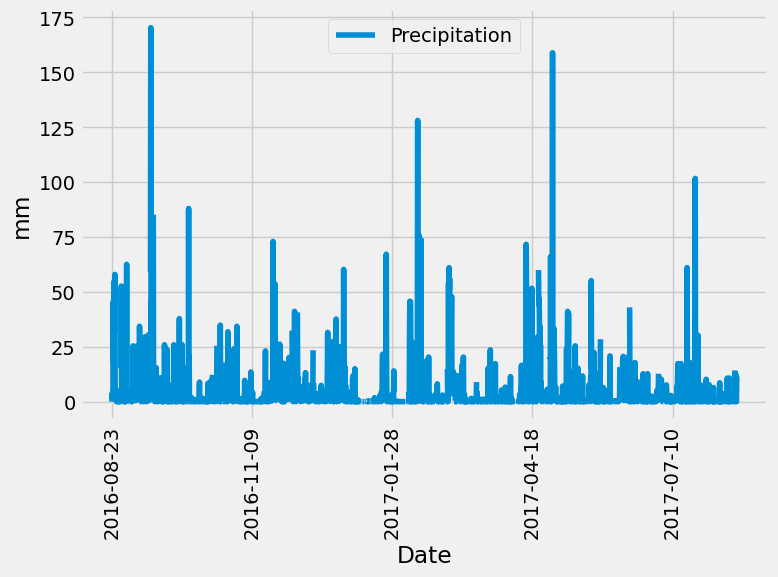

In [39]:
# Convert the most recent date string to a datetime object
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year ago from the most recent date
one_year_ago = most_recent_date - dt.timedelta(days=366)

# Perform a query to retrieve the previous 12 months of precipitation data
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    filter(Measurement.date <= most_recent_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. 
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the DataFrame values by "date"
precipitation_df = precipitation_df.sort_values(by='Date')

# Plot the results using the DataFrame plot method
ax = precipitation_df.plot(x='Date', y='Precipitation', kind='line', figsize=(8,6))
plt.xlabel('Date')
plt.ylabel('mm')
plt.xticks(rotation=90)
ax.legend(loc='upper center')

plt.tight_layout()
plt.show()

In [40]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = pd.DataFrame(precipitation_df['Precipitation'].describe())

# Print the summary statistics
summary_statistics

,Precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [41]:
# Design a query to calculate the total number of stations in the dataset
# Retrieve all stations in the dataset
stations_data = session.query(Station.station, Station.name).all()

# Calculate the total number of stations
total_stations = len(stations_data)

total_stations


9

In [42]:
# Design a query to find the most active stations
most_active_stations = session.query(Measurement.station,
                                     func.count(Measurement.station).label('count')).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all()

# Print the most active stations and their counts
for result in most_active_stations:
    print(f"Station: {result[0]}, Count: {result[1]}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [43]:
# Get the most active station ID from the previous query
most_active_station_id = most_active_stations[0][0]

# Calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).\
                     filter(Measurement.station == most_active_station_id).all()

# Print the lowest, highest, and average temperature
for result in temperature_stats:
    lowest_temp, highest_temp, avg_temp = result
    print(f"Most Active Station: {most_active_station_id}")
    print(f"Lowest Temperature: {lowest_temp} F")
    print(f"Highest Temperature: {highest_temp} F")
    print(f"Average Temperature: {avg_temp} F")

Most Active Station: USC00519281
Lowest Temperature: 12.2 F
Highest Temperature: 29.4 F
Average Temperature: 22.03582251082252 F


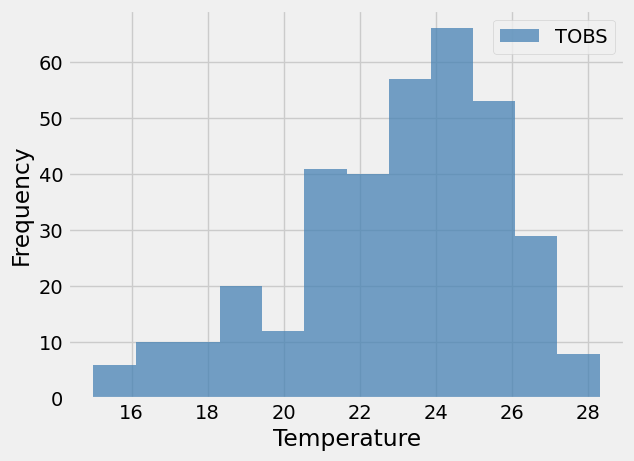

In [44]:

# Calculate the date one year ago from the most recent date in the dataset
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - dt.timedelta(days=366)

# Query the previous 12 months of TOBS data for the most active station
tobs_data = session.query(Measurement.tobs).\
                filter(Measurement.station == most_active_station_id).\
                filter(Measurement.date >= one_year_ago).all()

# Extract the TOBS values from the result
tobs_values = [result[0] for result in tobs_data]

# Plot the results as a histogram with bins=12
plt.hist(tobs_values, bins=12, color='steelblue', alpha=0.75)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['TOBS'], loc='upper right')
plt.show()


In [45]:
# Close Session
session.close()